In [6]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import spsolve
from utils import *

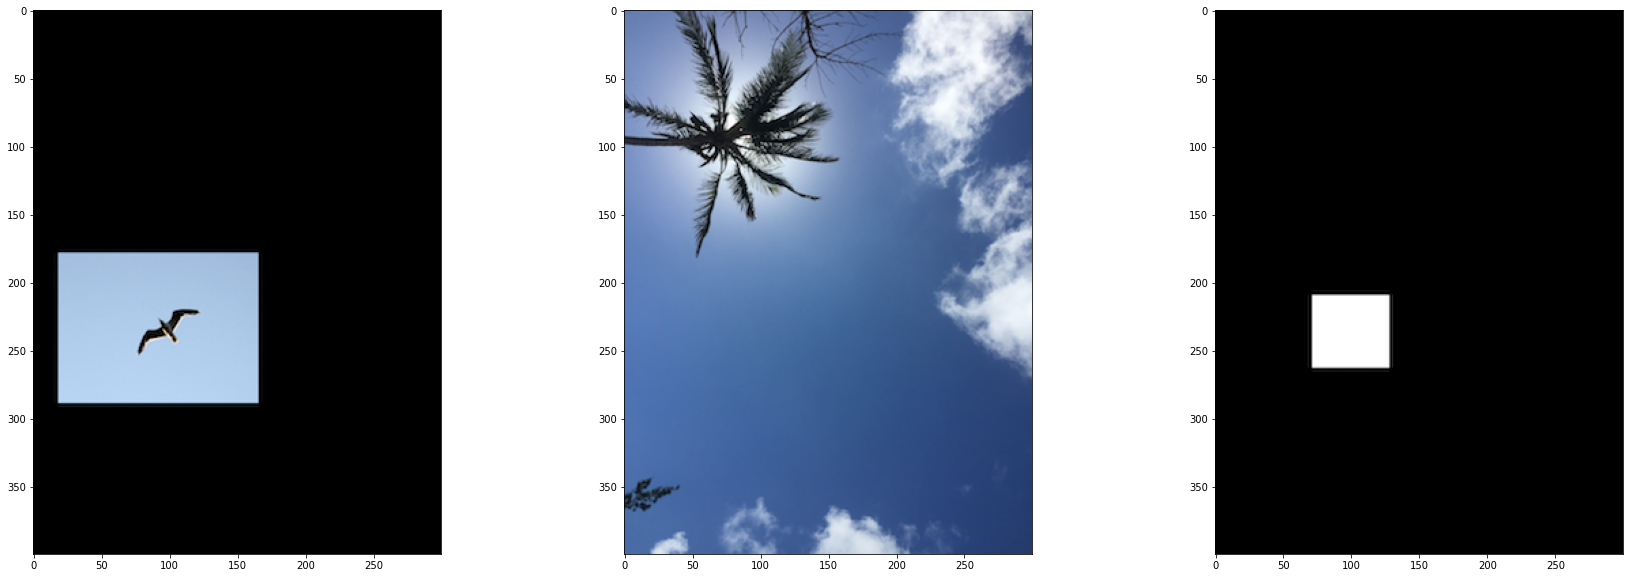

In [7]:
folder_path = "img/archive (2)/1/"

source = cv2.imread(folder_path + "source.png")
target = cv2.imread(folder_path + "target.png")
mask = cv2.imread(folder_path + "mask.png", cv2.IMREAD_GRAYSCALE) 

#let's plot the image to have a better understanding of the before and after
triple_image(source, target, mask)

In [10]:
def poisson_edit(source, target, mask, offset):
    # Calculate image dimensions
    height, width, channels = target.shape
    print(f"target: {target.shape}, source: {source.shape}, mask: {mask.shape}")
    # Create an affine transformation matrix to align the source with the target
    transformation_matrix = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
    source_warped = cv2.warpAffine(source, transformation_matrix, (width, height))

    # Extract and prepare the mask
    mask = mask[:height, :width]
    mask_binary = (mask != 0).astype(np.float32)

    # Create a Laplacian matrix
    laplacian = laplacian_matrix(height, width)

    # Modify the Laplacian matrix for boundary conditions
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if mask[y, x] == 0:
                k = x + y * width
                laplacian[k, k] = 1
                laplacian[k, k + 1] = 0
                laplacian[k, k - 1] = 0
                laplacian[k, k + width] = 0
                laplacian[k, k - width] = 0

    print("Solving linear system...")
    print(f"laplacian_matrix: {laplacian.shape}")
    # Flatten the source and target images
    source_flat = source_warped.reshape((-1, channels))
    target_flat = target.reshape((-1, channels))

    print(f"source_flat: {source_flat.shape}, target_flat: {target_flat.shape}")
    # Calculate Laplacian of the source image
    laplacian_source = laplacian.dot(source_flat)

    # Update Laplacian values outside the mask with target values
    laplacian_source[mask_binary.flatten() == 0] = target_flat[mask_binary.flatten() == 0]

    # Solve the linear system to get the blended image 
    laplacian = laplacian.tocsc()
    blended_flat = spsolve(laplacian, laplacian_source)

    # Clip pixel values to the [0, 255] range
    blended_flat = np.clip(blended_flat, 0, 255).astype('uint8')

    # Reshape and update the target image with the blended channel
    target = blended_flat.reshape((height, width, channels))

    return target

cv2.imwrite("test.png", poisson_edit(source, target, mask, (0, 0)))

SyntaxError: invalid syntax (3157722705.py, line 36)

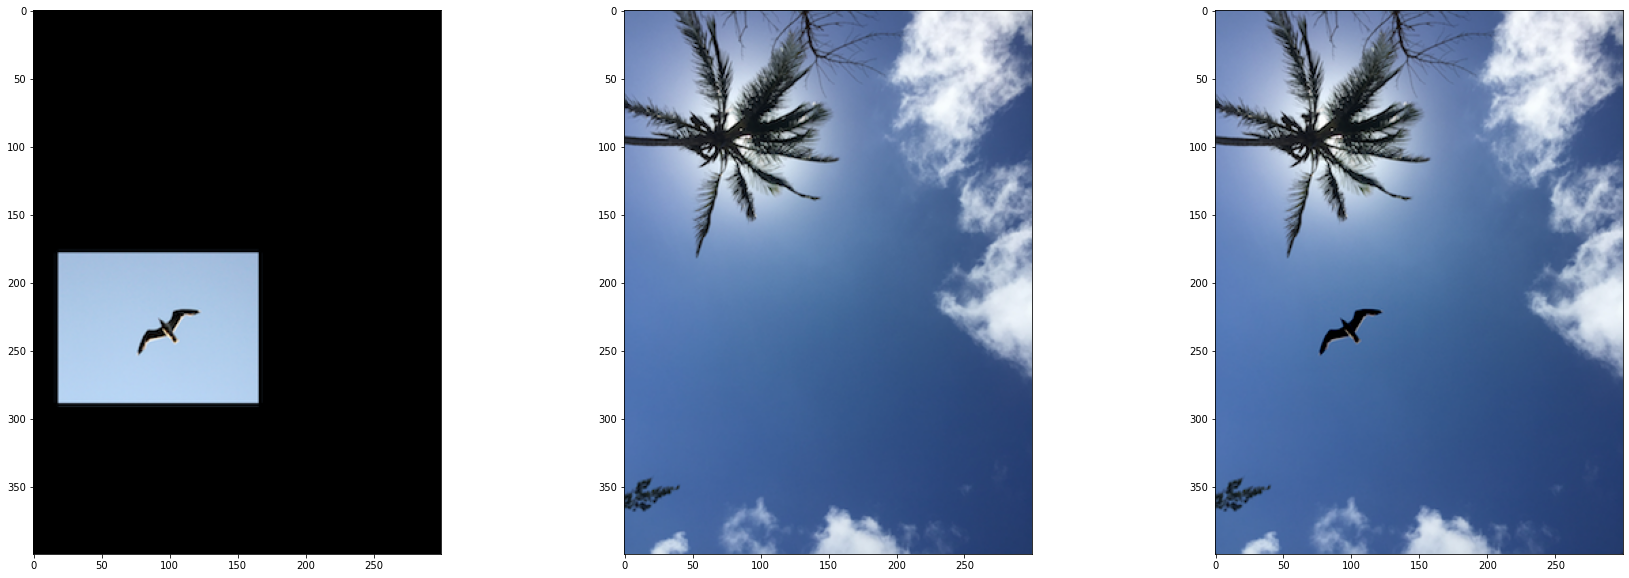

In [5]:
edited = cv2.imread("test.png")

triple_image(source, target, edited)